# Shop Analysis

## Load dependencies

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

from IPython.display import Image

In [2]:
from msci.utils import utils
from msci.analysis.networks import *

## Import data

In [3]:
signal_df = utils.import_signals('Mall of Mauritius', version=4, signal_type=1)

c:\users\tvb\envs\venv-msci\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### Mall of Mauritius

This is the largest of the three mall. It contains around 150 shops and recieves almost 700,000 people each month.

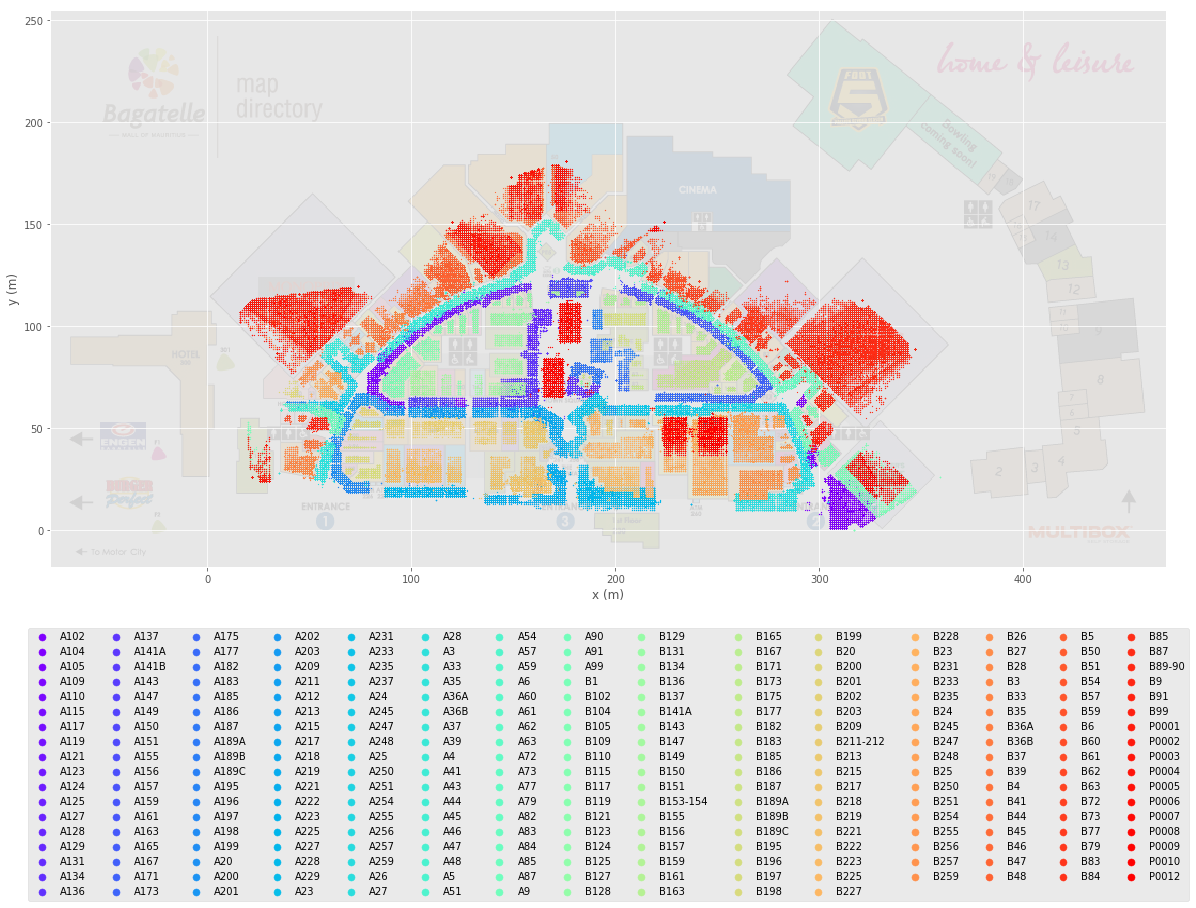

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

img = mpimg.imread("../../images/mall_of_mauritius_map.png")
axes.imshow(img[::-1], origin='lower', extent=[-77,470,-18,255], alpha=0.1)

mauritius_store_group = signal_df[signal_df.store_id.notnull()].groupby('store_id')
colors = iter(cm.rainbow(np.linspace(0, 1, len(mauritius_store_group))))
for key, group in mauritius_store_group:
    axes.scatter(group['x'], group['y'], s=0.5, color=next(colors), label=key)
    
axes.set_xlabel('x (m)')
axes.set_ylabel('y (m)')
axes.legend(loc='upper center', markerscale=10., ncol=15, bbox_to_anchor=(0.5, -0.1));

## Create Shop Data Frame

In [13]:
shops = signal_df[signal_df.store_id.notnull()].groupby('store_id')

shops = signal_df[signal_df.store_id.str[0] == 'B'].store_id.value_counts()
shop_df = pd.DataFrame(shops)
shop_df.rename(columns={'store_id': 'frequency'}, inplace=True)
shop_df['store_id'] = shop_df.index
shop_df.reset_index(inplace=True, drop=True)

In [20]:
def shop_areas(signal_df, shop_df):
    areas = []
    dimensions = []
    centroid = []
    shops = shop_df.store_id.tolist()

    signal_sorted_df = signal_df.sort_values('date_time')
    signal_store_group = signal_sorted_df.groupby('store_id')

    for shop in tqdm(shops, desc='Average Speed'):
        store_signals_df = signal_store_group.get_group(shop)
        xy = store_signals_df[['x', 'y']].as_matrix()
        centroid.append(list(np.mean(xy, axis=0)))
        pos = xy.tolist()
        key = list(set(xy[:, 0]))
        xy_dict = {k: [] for k in key}
        for (i, j) in pos:
            xy_dict[i].append(j)
        area = []
        dims = {}
        for k in key:
            y_max = np.amax(xy_dict[k])
            y_min = np.amin(xy_dict[k])
            area.append(y_max - y_min)
            dims[k] = [y_min, y_max]
        dimensions.append(dims)
        areas.append(np.sum(area))
    centroid_array = np.array(centroid)
    return areas, dimensions, centroid, centroid_array[:, 0], centroid_array[:, 1]

def add_count_of_shoppers(signal_df, shop_df):
    count_of_shoppers = []
    signal_group = signal_df.groupby('store_id')
    for shop in tqdm(shop_df.store_id.tolist(), desc='Count of shoppers'):
        group = signal_group.get_group(shop)
        count_of_shoppers.append(len(group.mac_address.unique()))
    return count_of_shoppers

In [21]:
shop_df['area'], shop_df['dimensions'], shop_df['centroid'], shop_df['x'], shop_df['y'] = shop_areas(signal_df, shop_df)
shop_df['count_of_shoppers'] = add_count_of_shoppers(signal_df, shop_df)

HBox(children=(IntProgress(value=0, description='Average Speed', max=126), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Count of shoppers', max=126), HTML(value='')))

## Create Shop Distance Matrix

In [ ]:
distance = lambda p1, p2: np.sqrt((p1.centroid[0] - p2.centroid[0])**2 + (p1.centroid[1] - p2.centroid[1])**2)

shop_distance_matrix = np.zeros((len(shop_df), len(shop_df)))

for i in tqdm(range(shop_distance_matrix.shape[0])):
    for j in range(shop_distance_matrix.shape[1]):
        shop_distance_matrix[i][j] = distance(shop_df.iloc[i], shop_df.iloc[j])

In [ ]:
def direction(p1, p2):
    return (p1.centroid[0] - p2.centroid[0]), (p1.centroid[1] - p2.centroid[1])

shop_direction_matrix = np.zeros((len(shop_df), len(shop_df), 2))

for i in tqdm(range(shop_direction_matrix.shape[0])):
    for j in range(shop_direction_matrix.shape[1]):
        shop_direction_matrix[i][j] = direction(shop_df.iloc[i], shop_df.iloc[j])

In [ ]:
shop_direction_matrix.shape

## Output Shop Data Frame

In [23]:
shop_df.to_csv('mauritius_directoryv2.csv', index=False)

## Store area vs number of visitors

In [ ]:
from scipy.stats import linregress

In [ ]:
area_shop_df = shop_df[(shop_df.area > 0) & (shop_df.count_of_shoppers > 0)]

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

ax.scatter(area_shop_df.area, area_shop_df.count_of_shoppers, label='Raw data')

slope, intercept, x_value, p_value, std_err = linregress(
    np.log10(area_shop_df.area), np.log10(area_shop_df.count_of_shoppers)
)
area_fit = np.linspace(1, 10**4, 10)
count_of_shoppers_fit = [10**intercept*x**slope for x in area_fit]
ax.plot(area_fit, count_of_shoppers_fit, 'b--', label='Power Law Fit ($Ax^{\gamma}$) \n $\gamma=0.61 \pm 0.04$')

ax.set_xlabel('Area of store ($m^2$)', fontsize=15)
ax.set_ylabel('Number of shoppers', fontsize=15)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=15)

# fig.savefig('area_vs_number_of_shoppers.eps', format='eps', transparent=True)